In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build dataset
block_size = 3

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# ------------ actual model organized ------------------

In [8]:
# utility function we will use later when comparing manual gradients to PyToch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exactL {str(ex):5s} | approximate: {str(app):5s} | maxdiff:{maxdiff}')

In [10]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of nuerons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5) # * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden,vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1

bngain = torch.ones((1,n_hidden)) * 0.1 + 1
bnbias = torch.zeros((1,n_hidden)) * 0.1
# bnmean_running = torch.zeros((1,n_hidden))
# bnstd_running = torch.zeros((1,n_hidden))


parameters = [C,W1,b1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1
    # BatchNorm layer
    # --------------------------------------------------------------

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.mean(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # with torch.no_grad():
    #     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    #     bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb)
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break
    

      0/ 200000: 3.3321
  10000/ 200000: 2.2316
  20000/ 200000: 2.2947
  30000/ 200000: 2.6070
  40000/ 200000: 1.9446
  50000/ 200000: 2.4492
  60000/ 200000: 2.4521
  70000/ 200000: 2.1326
  80000/ 200000: 2.2921
  90000/ 200000: 2.2075
 100000/ 200000: 1.8338
 110000/ 200000: 2.2630
 120000/ 200000: 2.0206
 130000/ 200000: 2.5103
 140000/ 200000: 2.3618
 150000/ 200000: 2.1838
 160000/ 200000: 2.0970
 170000/ 200000: 1.7998
 180000/ 200000: 2.0456
 190000/ 200000: 1.8465


In [8]:
# not needed bcuz bnmean_running and bnstd_running are mostly identical to bnmean and bnstd

# # calibrate the batch norm at the end of training

# with torch.no_grad():
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0, keepdim = True)
#     bnstd = hpreact.std(0, keepdim = True)

In [9]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (32, 3, 2)
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0793254375457764
val 2.1169991493225098


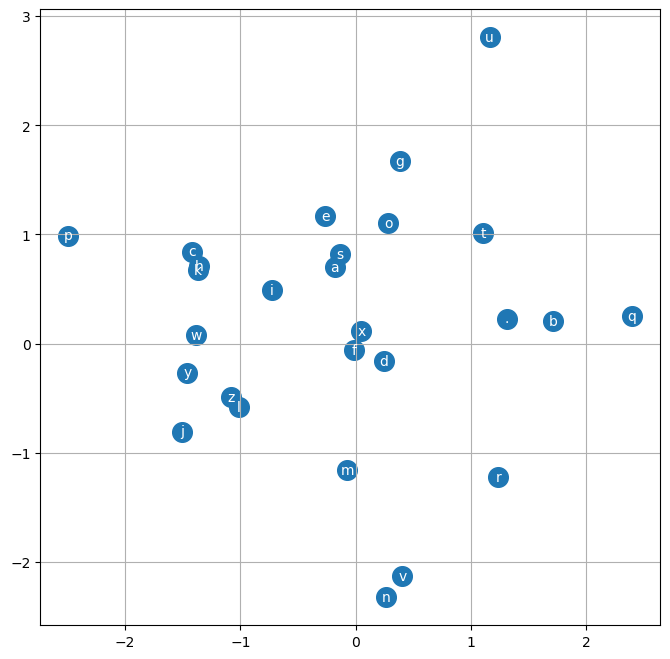

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [11]:
# training split (tuning parameters), dev/validation split (tuning hyper parameters), test split
# 80%, 10%, 10%

In [21]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mora.
mayah.
see.
mel.
rylle.
emmadiendraeg.
aderydielin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shuberlyni.
jest.
jair.
jeniquetton.
kunne.
cel.
kylynn.
